In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from numba import jit, autojit
from scipy.sparse import csc_matrix, dia_matrix, diags
from scipy.sparse.linalg import eigs, eigsh

In [3]:
x = np.linspace(-10,10,10001)

In [4]:
# Initialise constants for the softcore potential:
v = 2 # set =0 for particle in a box case
n = 2
b = 2

@np.vectorize
def potential(xk):
    numerator = -v
    denominator = (np.abs(xk)**n + b**n)**(1/n)
    return numerator/denominator

In [5]:

def gen_Hamiltonian(x_arr):
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    H = np.zeros((len(x_arr),len(x_arr)))
    for i,val in enumerate(x_arr):
        H[i][i] = potential(val) - (5/2)*dx2
        if i-1>=0:
            H[i][i-1] = (4/3)*dx2
        if (i+1)<len(x_arr):
            H[i][i+1] = (4/3)*dx2
        if i-2>=0:
            H[i][i-2] = (-1/12)*dx2
        if (i+2)<len(x_arr):
            H[i][i+2] = (-1/12)*dx2
    return H

@autojit
def gen_diag_Hamiltonian(x_arr):
    
    dx2 = -1/(2*(np.abs(x_arr[0]-x_arr[1])**2))
    V = potential(x_arr)
    
    centre_diag = V - (5/2)*dx2
    one_off_diag = (4/3)*np.ones_like(x_arr[:-1])*dx2    
    two_off_diag = -(1/12)*np.ones_like(x_arr[:-2])*dx2
    
    H = diags([centre_diag,one_off_diag,one_off_diag,two_off_diag,two_off_diag],[0,1,-1,2,-2])
    return H

In [6]:
H = gen_diag_Hamiltonian(x)

In [7]:
# biggest_abs_val = eigs(H,k=1)[0][0]
biggest_abs_val = 55
eig_vals,eig_vecs = eigsh(H, k=5, sigma=-biggest_abs_val)
#pairs = eigs(H, k=len(x)-2) # assigns pairs to be a tuple with 2 elements; eigenvalues and eigenvectors
#eig_vals = [x for x,y in sorted(zip(*pairs))] # *pairs unpacks pairs into two arrays
#eig_vecs = [y for x,y in sorted(zip(*pairs))]

0.38150787353515625
373.84033203125


<IPython.core.display.Javascript object>


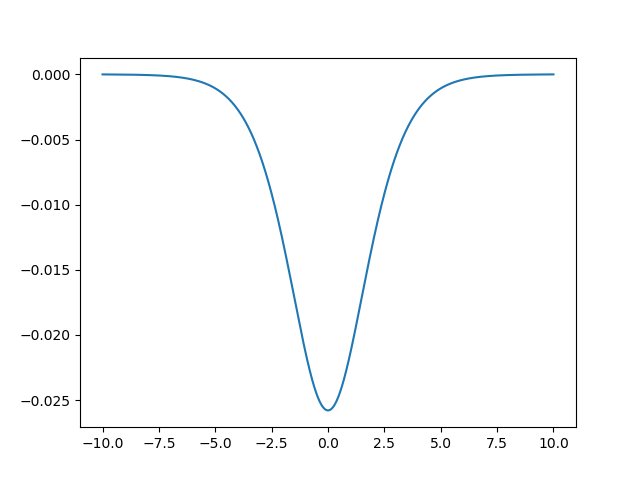

In [8]:
print(H.data.nbytes/(1024**2)) # 10million x 10million matrix
print(np.random.rand(7000,7000).nbytes/(1024**2))
plt.figure()
plt.plot(x, eig_vecs[:,0])

In [14]:
 # re-write this, don't need an array
dt = 1e-8
def time_step(previous_eigstate, dt):
    evolved_part = (H*previous_eigstate)
    new_eigstate = previous_eigstate + 1j*dt*evolved_part
    return new_eigstate

<IPython.core.display.Javascript object>


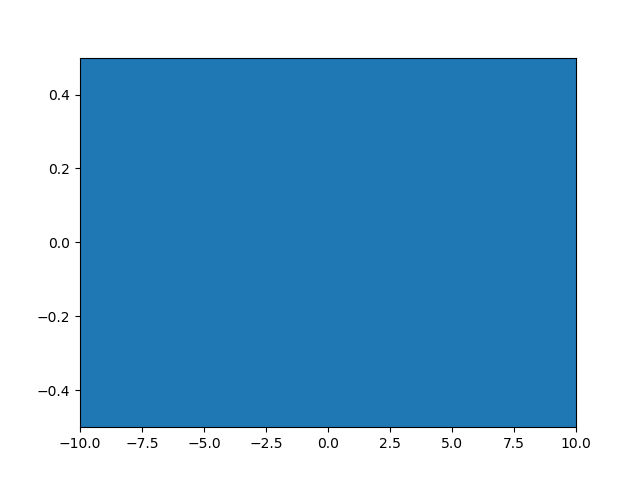

In [15]:
import matplotlib.animation as animation


def data_gen(t=0):
    i = 0
    previous_eigstate = eig_vecs[:,0]
    while i < 1000000:
        i += 1
        for j in range(1000):
            updated_eigestate = time_step(previous_eigstate, dt)
            previous_eigstate = updated_eigestate
        yield x, updated_eigestate, i


def init():
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(-10, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)
ax.grid()
xdata, ydata = [], []


def run(data):
    # update the data
    x, y, t = data
    xdata = x
    ydata = y
    xmin, xmax = ax.get_xlim()
    ax.set_label('test')
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init,)
plt.show()